In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

In [2]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 2 + 1 + 1 + 2)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 2 + 1 + 1 + 2))
        new_data[0, 0:2] = state
        new_data[0, 2:4] = [action, reward]
        if not done:
            new_data[0, 4:] = next_state 
        else:
            new_data[0, 4:] = [np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [3]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 1024)
        self.l4 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [15]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))        
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 350)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

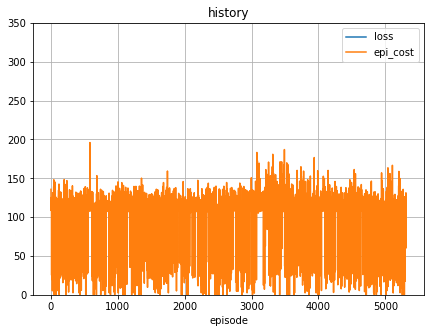

KeyboardInterrupt: 

In [10]:
buffer_size = 10000
buffer = Buffer(buffer_size)

name = "dqs_3"
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions=21, trained_model='../../models/dqs_3')
batch_size = 16
epsillon = 0.2

e = 1
no_epi = 10000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [3, 3, 2], no_actions=21)

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
#     v_init = 8*(np.random.rand() - 0.5)
    v_init = 1.5*(np.random.randint(3) - 1)
    state = env.reset_env([0.0, v_init], no_steps*step_time)
    if e % 500 == 0 and e > 10:
        torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

In [16]:
# this block is to load a stepper
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/oned/dqs_3', no_actions = 21)

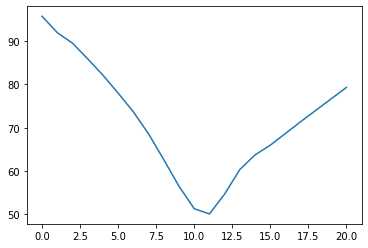

In [20]:
## visualising the q values
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0.0]))
q_arr.append(dqs.predict_q([0, 1]))

plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[0])
plt.show()

In [23]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [2, 2, 4], no_actions=21)

state = env.reset_env([0.0, -1.0], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action)
    next_state, cost, done = env.step_env(action, step_time)
    state = next_state
    epi_cost += cost
    if done:
        print(epi_cost)
        break
print("showing simulation...")  
env.show_episode(5, 1)

0
6
8
8
8
8
1
12
10
10
showing simulation...


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABBLG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA6HZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwTZP1ApEOAKLGJP0SpUh2XxRDdCJTc
ZzZ4v4cZYQuR+HDQoeqd8MgYlM90eLyIShBlFOfsfeC3y6ZMB6mIjbVgfgAAAwCHrYt4WrCE2FYv
soOKL18FFh6KEO0+xpWmSScXj1JLKqArswGLk2qWuFWZ9VDPZBMhWASqGjdGSGAKi7OT8kWUDOCa
JMn6zKbjXSR06XShN15KxK0szcoGeRpx+vJZZfOx/943m+4cMLBNZZyPR1p/0c8DzanAmAh4Ye5L
aixpPshaN0s28EtyC2y8zN5ycW6mGS4ZGMZlAkWZ0zhZ4kA/pKqRb8z/I325jP/ZTDplYHAjvM8P
JPmYXM0VDSMw8/8wbtsnsKYIOnmzqfnVUcXZGMkieb3NcSvzzg/RF/LiqBse0KHPhe6vaFRrS4Dg
6acssnRINcyUxsJb5/Ejdfu4Yt6az5IoimmAASM4MiaKG9wbIX+rzNvcAEyxy8Aeg2LQJ0zAdW1O
VNCyYkf6Poj/b67lurK1vxOnwtWi6wx4WZGmxt/+e2TA/vokWYYQpbJR/TTPkVCmJy6Y+CUYUSS2
KE5koJXa0/bBGIjnzsgq4+FBz4BQBsQi3goTaCc3a9gwcTGyKfRcWMWyysRR/KOfjziLSPSCTTbW
OreJG0pulYL3McU9Acczv28tmXRfRBcI44CAk/rsIN9hKhGsjX+qKnTPeoddsMXt/7rDe8HBovQg
Qcn60ZMhXc5LQYyINJEOYLLzhcmFFsy93RuqOlu3jkMdgZOTyDF6DTEjQ23UjCIoZM0VBRUEkXa/
QnYXtZhghzPdYop9dtdmsS6szxAAgAXrSKGppTXmriQp9Clts+FncE+PfnNIXRGsOfqApcpIrfQX
qMJZvk7OfthldIqBwxxyOLhLV2eDRL0PWfrM2Au6nCBHvdF35zN3FrdmRm3zyWaqzJFQ0WIVgMVH
9WAunw56/3JmrGegFFOm3Tk9R9HQ3kXOLXoIrHnTLj5apoIvXuPBQVeWKAAAAwAC5Gz7ipGTAeot
dM0d6LC+a9IIaBJYIi08dS3j2gaPE1IwpvFGT4e6rNFTaf1Kbp4CxghINW27pYqz1bgaO+hXnxNL
881Ryz917fyO8TXj9sw8lTZFQvsZwMgDi1OX+M//bWgg5eE5r/4AAO2R6MIIG5K54/s4Gxd1VhOG
bwj2NQwUdqv6YmFSn/+rCGE74AcldK34GCGNIOduoV65a+4Tkvk22/8BwGfRVyGayha2SOp7IqiR
VMtXpDCSV7GcjxSgLdu6RlKKybDQGE38bjBttaYk/HJaBUSbFbsvSA5fZhWv4UE5wURlJ55pdfZJ
dJ1sbE1xsfvS7LyraHtoDNbOIx0EPyLzG1SzAA23cQOVfdeD7PceJzWYhYZAz9l0voLLPNbvi/Vj
vP3nr9/2s4hmUoodwu8yWtXoG2momuFJGtpIwWpagNIcMj+jSqxpS1NTl8Vk0aR85oMC3eixMAie
SyHnvGYJh9ZwfxIu+BVrPsA7pHz44jY61y2yAHugMmsH1tuHr898UFrThkDSTIJ86c7dc1MTuAdg
vsSBx02tXNsgO/B3hyuEmWcLfNxxxDbEy/xYRovQGzIAC9aRPg0Ulwb/1oPG2jpjlZgee//wxncE
Rh5qH9RtGAlfr3DLeWrgRrkKmKNFme/lYXCXIMqpN1CzONdErzQlBSR8vdx7u00Y15I6xgKNpu6x
HwWB9NDadr7MSR3F/KuO5PNClebFmEATimRWRRIVzlR09XnPNHn6TaBcZK25o595FiiFDE4SQBJ+
UhFxcgSN4G+Jue1I/VHKpsDsWoFjpPKg1lhTADL85+W4bl7g6PllIlbswjROYODv3Xkmb67poM8s
tAJlIyNehgHi1Yz3kKDY6Mmv/M/tW2SC4rusIArCMG63f2gG8k8lranY4jBvczrU8VPWLDoqkhdb
Lb1Ga0hIX+rDK1W+5TC4+njFb/vSIlDXcLX1EHPbEYxm8zDvOPHZv6fCwRE+AW1LuSFL8Lw/qkzt
JXDdUFYcfLXVkINnjdFOYpLKZXq+yED8I6vAsOdEbmC0Lj5yJQpfJvHoIJ7qoEuubNyJx9VCcYDZ
ijZNCeTciIIBl7CtfqBPtefPPtgoz3EMf8yD+EZjCvyaG/b8rHblvdMzN65ugJAEBcW0FbXAXc+j
DFZrDPJ3ZevNpc3k4+LuhqTCHif2P8bOw8wHhGADN+gDE39d8aPcvTH28PnrpMz+TQJywUT8l8kY
cOuSE8VV7QK0rnL5/Xcgzb9MRPdOoQZkHgx+FpNjqnZ/wSRg0YW49JoYGN+BIJ0K/22leiW0o7BL
wT4GD0u46VWbdsDOrvfH+fkZxNSm63Bv79tdYgTP1BFy+1Ml/D+OrsCP5hDfF4MhZQKdAQ5Bg4n8
2S37Sgqfvt+asHHfIp9hB+WjN+5i/k2/xmKupz3yuuhdZwvPjEKIA83/2XKmoAIs5wVPdQJ//a/4
g3301PFcw7Vglfx/XzwrT6geAfcMHyz8s/MQwY6qiVTyr2oJHyLBl93JIvtjs9gwFiK7XXhkeFcV
YfunU4gTQl/bhssGf0EyeADv/U4WtlkK0WT6m++Dtqbcj+YXNwkKIcEAvlroCoTvsZwzUPvH1eq/
PloSH+AIHLzdvSvq+ddjGjY/EXpayvQmd2Z9JA9mBVnrpE6v5AXT20K4t4Y6bK4ihSNGRV/0lz9j
5uj+5bRnHtwd1KWP0nsuZcG3Wl6QYie4x2xoCy1RDH5eelRBUuuUraOxdvWDxtJ//92/4yZ3YdAE
qhERO6GrvpYcvNN8KKeqsUdwixei6lB6Fw55ksbgRyJAe/MncPibfyb7frvBldKOB1cdtfOzhro6
DJSXn8cTEabplxAN9WRFJ